In [71]:
# Run this cell to set up the notebook, but please don't change it.
import otter
import numpy as np
import math
# These lines set up the plotting functionality and formatting.
import matplotlib
%matplotlib inline

import datascience
from datascience import *

import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter("ignore")

# Project 2: Movie Classification

# Part 1: The Dataset

We are exploring movie screenplays in this project, trying to predict each movie's genre from the text of its screenplay. In particular, we have compiled a list of 5,000 words that occur in conversations between movie characters. For each movie, our dataset tells us the frequency with which each of these words occurs in certain conversations in its screenplay. All words have been converted to lowercase.

The following code when run reads `movies` table. **It may take up to a minute to load.**

In [72]:
movies = Table.read_table('movies.csv')

Here are one of the rows of the table and some of the frequencies of words that were said in the movie.

In [73]:
movies.where("Title", "runaway bride").select(0, 1, 2, 3, 4, 14, 49, 1042, 4004)

Title,Year,Rating,Genre,# Words,breez,england,it,bravo
runaway bride,1999,5.2,comedy,4895,0,0,0.0234092,0


The above cell prints a few columns of the row for the comedy movie Runaway Bride. The movie contains 4895 words. The word "it" appears 115 times, as it makes up of the words in the movie. The word "england" doesn't appear at all.

Additional context: This numerical representation of a body of text, one that describes only the frequencies of individual words, is called a bag-of-words representation. This is a model that is often used in NLP. A lot of information is discarded in this representation: the order of the words, the context of each word, who said what, the cast of characters and actors, etc. However, a bag-of-words representation is often used for machine learning applications as a reasonable starting point, because a great deal of information is also retained and expressed in a convenient and compact format.

In this project, we will investigate whether this representation is sufficient to build an accurate genre classifier.

All movie titles are unique. The `row_for_title` function provides fast access to the one row for each title. 

*Note: All movies in our dataset have their titles lower-cased.* 

In [74]:
title_index = movies.index_by('Title')
def row_for_title(title):
    """Return the row for a title, similar to the following expression (but faster)
    
    movies.where('Title', title).row(0)
    """
    return title_index.get(title)[0]

row_for_title('toy story')

Row(Title=np.str_('toy story'), Year=np.str_('1995'), Rating=np.float64(8.2), Genre=np.str_('comedy'), # Words=np.int64(3016), she=np.float64(0.0017427675148135), decid=np.float64(0.0003485535029627), talk=np.float64(0.0017427675148135), wit=np.float64(0.0), razor=np.float64(0.0), slam=np.float64(0.0), credit=np.float64(0.0), rai=np.float64(0.0), hugh=np.float64(0.0), breez=np.float64(0.0), conscienc=np.float64(0.0), audienc=np.float64(0.0), cathi=np.float64(0.0), log=np.float64(0.0), met=np.float64(0.0), chosen=np.float64(0.0), grip=np.float64(0.0), booz=np.float64(0.0), bianca=np.float64(0.0), doubl=np.float64(0.0003485535029627), agent=np.float64(0.0), exit=np.float64(0.0), carpent=np.float64(0.0), underground=np.float64(0.0), clemenza=np.float64(0.0), gain=np.float64(0.0), neg=np.float64(0.0006971070059254), majesti=np.float64(0.0), studio=np.float64(0.0), chri=np.float64(0.0), spin=np.float64(0.0), greater=np.float64(0.0), eaten=np.float64(0.0), vibrat=np.float64(0.0), stupid=np.f

For example, the fastest way to find the frequency of "fun" in the movie *Toy Story* is to access the `'fun'` item from its row. Check the original table to see if this worked for you!

In [75]:
row_for_title('toy story').item('fun')

np.float64(0.0003485535029627)

Question 1.0
Set expected_row_sum to the number that you expect will result from summing all proportions in each row, excluding the first five columns. Think about what any one row adds up to.

In [76]:
# Set row_sum to a number that's the (approximate) sum of each row of word proportions.
expected_row_sum = 1



This dataset was extracted from a dataset from Cornell University. After transforming the dataset (e.g., converting the words to lowercase, removing the naughty words, and converting the counts to frequencies), we created this new dataset containing the frequency of 5000 common words in each movie.



In [77]:
print('Words with frequencies:', movies.drop(np.arange(5)).num_columns) 
print('Movies with genres:', movies.num_rows)

Words with frequencies: 5000
Movies with genres: 333


1.1. Word Stemming
The columns other than "Title", "Year", "Rating", "Genre", and "# Words" in the movies table are all words that appear in some of the movies in our dataset. These words have been stemmed, or abbreviated heuristically, in an attempt to make different inflected forms of the same base word into the same string. For example, the column "manag" is the sum of proportions of the words "manage", "manager", "managed", and "managerial" (and perhaps others) in each movie. This is a common technique used in machine learning and natural language processing.

Stemming makes it a little tricky to search for the words you want to use, so we have provided another table called vocab_table that will let you see examples of unstemmed versions of each stemmed word. Run the code below to load it.

Note: You should use vocab_table for the rest of Section 1.1, not vocab_mapping.

In [78]:
# Just run this cell.
vocab_mapping = Table.read_table('stem.csv')
stemmed = np.take(movies.labels, np.arange(3, len(movies.labels)))
vocab_table = Table().with_column('Stem', stemmed).join('Stem', vocab_mapping)
vocab_table.take(np.arange(1100, 1110))

Stem,Word
bond,bonding
bone,bone
bone,boning
bone,bones
bonu,bonus
book,bookings
book,books
book,booking
book,booked
book,book


#### Question 1.1.1
Using `vocab_table`, find the stemmed version of the word "elements" and assign the value to `stemmed_message`.


In [79]:
stemmed_message = vocab_table.where("Word", are.equal_to("elements")).column("Stem").item(0)
stemmed_message

'element'

#### Question 1.1.2
What stem in the dataset has the most words that are shortened to it? Assign `most_stem` to that stem. 

In [80]:
most_stem = vocab_table.group("Stem").sort("count", descending = True).column("Stem").item(0)
most_stem

'gener'


What is the longest word in the dataset whose stem wasn't shortened? Assign that to longest_uncut. Break ties alphabetically from Z to A (so if your options are "cat" or "bat", you should pick "cat"). Note that when sorting letters, the letter a is smaller than the letter z. You may also want to sort more than once.

In [81]:
tbl_with_lens = vocab_table.with_column("lens of word", vocab_table.apply(len, "Word")).with_column("lens of stem", vocab_table.apply(len, "Stem"))
tbl_with_diff = tbl_with_lens.with_column("difference between those lengths", tbl_with_lens.column("lens of word") - tbl_with_lens.column("lens of stem"))

longest_uncut = tbl_with_diff.sort("difference between those lengths", descending = False).where("difference between those lengths", are.equal_to(0)).sort("Word", descending = True).sort("lens of word", descending = True).column("Word").item(0)



longest_uncut

tbl_with_diff

Stem,Word,lens of word,lens of stem,difference between those lengths
a,a,1,1,0
ab,ab,2,2,0
ab,abs,3,2,1
abandon,abandon,7,7,0
abandon,abandoned,9,7,2
abduct,abduct,6,6,0
abduct,abducted,8,6,2
abduct,abduction,9,6,3
abil,ability,7,4,3
abil,abilities,9,4,5


#### Question 1.1.4
How many stems have only one word that is shortened to them? For example, if the stem "book" only maps to the word "books" and if the stem "a" only maps to the word "a," both should be counted as stems that map only to a single word.

Assign `count_single_stems` to the count of stems that map to one word only. 

In [82]:
count_single_stems = np.count_nonzero(tbl_with_diff.column("difference between those lengths") <= 0)
count_single_stems

np.int64(3754)

## 1.2. Exploratory Data Analysis: Linear Regression

Let's explore our dataset before trying to build a classifier. To start, we’ll use the associated proportions to investigate the relationship between different words.

The first association we'll investigate is the association between the proportion of words that are "outer" and the proportion of words that are "space".

As usual, we'll investigate our data visually before performing any numerical analysis.

Run the cell below to plot a scatter diagram of "space" proportions vs "outer" proportions and to create the outer_space table. Each point on the scatter plot represents one movie.



Title                      | Year | Rating | Genre    | # Words | she        | decid       | talk        | wit         | razor | slam | credit      | rai        | hugh | breez | conscienc   | audienc | cathi | log  | met         | chosen | grip        | booz        | bianca     | doubl | agent       | exit        | carpent | underground | clemenza | gain        | neg         | majesti | studio | chri        | spin        | greater     | eaten | vibrat | stupid      | cigarett    | jesu        | mani        | violin | financi     | bai         | cop         | neighbor    | cd   | england | made        | conni | instinct | took        | jacquelin | mace        | disappear  | waltz | behind      | bourbon | favorit     | benni       | manhattan | nixon | lunch       | principl    | tradit      | counterfeit | sophi | third       | exist       | wouldv      | hero        | theyr       | anytim      | christin | vallei | chess | paid        | burglar | nostril | rubber | human       | british     | plissken | eddi       | gee         | offend      | rebecca | anger       | plant     | famou      | repres      | latest | rent | dip         | bell | andi | so         | london | cooler      | keaton | portland | headlin     | whatta | fatal | sew  | cheer       | davi        | feed        | hudson | ambros | digest | redi | fri         | staff | casino      | occasion | shadow      | work        | restrain | face        | exercis | sidnei | pile | whyd        | teenag      | her         | retir       | hazard | roth | hurrican | impuls | ranger      | pour        | lester | slash | deer | could       | vital | qualiti | coma | incred      | hank        | famili      | duchess | global | virgin      | scientif | between     | holidai     | qualifi | moor | happili | arizona | non         | bruce       | ankl        | constant    | buzz | harder      | ing  | christian   | palmer | tent        | sunset      | damour | cohaagen | advertis | sensat | local       | there      | terri       | sedat | rotten | struck      | deck | past        | bro  | ann         | dump        | kane | slot        | immun | block       | lil  | technic     | tactic | pencil | outsid      | laboratori | easi        | nephew | coffin      | pretti      | coward | verbal      | permiss     | bartend     | wont        | watch       | lindenmey | cosmo      | capabl      | flirt | huge        | berkelei | max  | walter | lime | rico | marvin | aboard      | bacon | account | kirk | quaid | stunt | closet      | due         | nuclear | blind       | pussi       | howdi | snuff       | eas  | now        | leak        | underwear   | westlei | mayb        | theo | limo        | cousin      | illeg       | silli       | against     | done        | district | invad       | ryan | wait        | grudg | charact | hick | jami | lifetim | lecktor | and        | republican | life        | hidden      | wire        | paranoia | network     | messi | uthatu | effort      | carri       | windham | fun         | psychologist | sean | scent | answer      | mom         | wake        | sign        | ho   | relat       | jame | fat         | myself      | disrupt     | scan | vagu        | basket | christma | estim | em          | union | involv      | norman | suspici     | becom       | shoe        | librari     | administr | ford | complic | stuck       | justic      | attack      | releas | econom | hesit       | autopsi | jurisdict | four        | factor | inquiri | lion | meanwhil | prison      | blair | seri       | groceri | surgeri     | season | christi    | clean       | ow          | wrestl | en   | moral       | hungri      | cole | surfer | sixteen     | angl        | shame       | barrel | major       | ago         | lott | airplan | worth       | train       | easili | feller | valentin | harvei | wherev      | francisco   | true        | dramat | boston      | besid       | inspector | orlean | opportun    | nearli | lindsei | photograph | frame | at         | psy

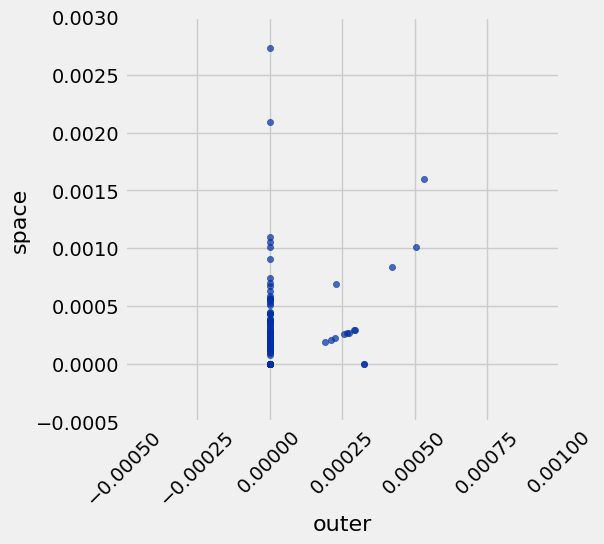

In [83]:
# Just run this cell!
outer_space = movies.select("outer", "space")
outer_space.scatter("outer", "space")
plots.axis([-0.0005, 0.001, -0.0005, 0.003]);
plots.xticks(rotation=45);

movies


Looking at that chart it is difficult to see if there is an association. Calculate the correlation coefficient for the potential linear association between proportion of words that are "outer" and the proportion of words that are "space" for every movie in the dataset, and assign it to `outer_space_r`. 

In [84]:
# These two arrays should make your code cleaner!
outer = movies.column("outer")
space = movies.column("space")


def standard_units(arr):
    mean = np.mean(arr)
    deviation = arr - mean
    std = np.std(arr)
    return deviation / std

def correlation(tbl, x_col, y_col):
    return np.mean(standard_units(tbl.column(x_col)) * standard_units(tbl.column(y_col)))
outer_su = standard_units(outer)
space_su = standard_units(space)

outer_space_r = correlation(movies, "outer", "space")
outer_space_r

np.float64(0.3194260787689591)

Choose two *different* words in the dataset with a magnitude (absolute value) of correlation higher than 0.2 and plot a scatter plot with a line of best fit for them. Please do not pick "outer" and "space" or "san" and "francisco". The code to plot the scatter plot and line of best fit is given for you, you just need to calculate the correct values to `r`, `slope` and `intercept`. 

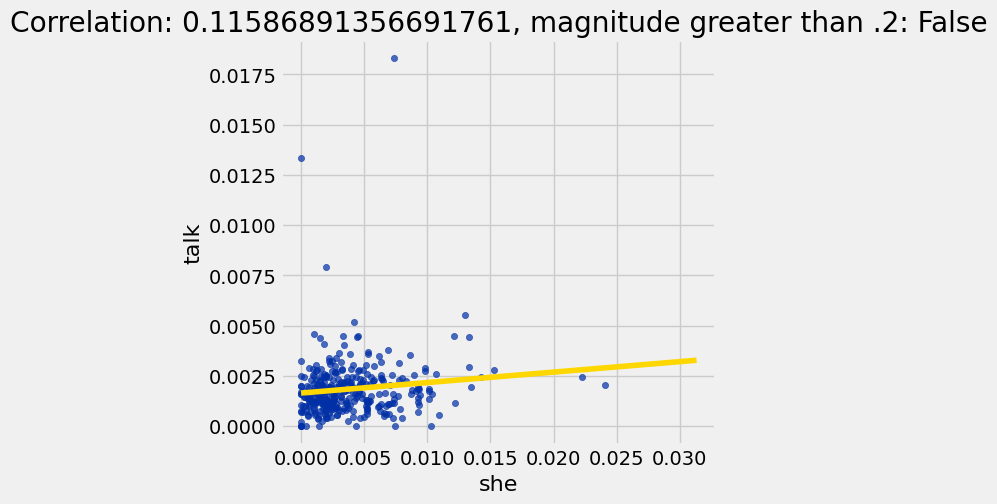

In [85]:
word_x = "she"
word_y = "talk"

# These arrays should make your code cleaner!
arr_x = movies.column(word_x)
arr_y = movies.column(word_y)

x_su = standard_units(arr_x)
y_su = standard_units(arr_y)

r = correlation(movies, word_x, word_y)

def fit_line(tbl, x_col, y_col):
    r = correlation(tbl, x_col, y_col)
    slope = r * np.std(tbl.column(y_col))/ np.std(tbl.column(x_col))
    intercept = np.mean(tbl.column(y_col)) - np.mean(tbl.column(x_col)) * slope
    arr = make_array(slope, intercept)
    return arr
slope = fit_line(movies, word_x, word_y).item(0)
intercept = fit_line(movies, word_x, word_y).item(1)

# DON'T CHANGE THESE LINES OF CODE
movies.scatter(word_x, word_y)
max_x = max(movies.column(word_x))
plots.title(f"Correlation: {r}, magnitude greater than .2: {abs(r) >= 0.2}")
plots.plot([0, max_x * 1.3], [intercept, intercept + slope * (max_x*1.3)], color='gold');

Question 1.2.3
Imagine that you picked the words "san" and "francisco" as the two words that you would expect to be correlated because they compose the city name San Francisco. Assign san_francisco to either the number 1 or the number 2 according to which statement is true regarding the correlation between "san" and "francisco."

"san" can also precede other city names like San Diego and San Jose. This might lead to "san" appearing in movies without "francisco," and would reduce the correlation between "san" and "francisco."
"san" can also precede other city names like San Diego and San Jose. The fact that "san" could appear more often in front of different cities and without "francisco" would increase the correlation between "san" and "francisco."

In [86]:
san_francisco = 1

## 1.3. Splitting the dataset
Now, we're going to use our `movies` dataset for two purposes.

1. First, we want to *train* movie genre classifiers.
2. Second, we want to *test* the performance of our classifiers. 

Hence, we need two different datasets: *training* and *test*. 

The purpose of a classifier is to classify unseen data that is similar to the training data. The test dataset will help us determine the accuracy of our predictions by comparing the actual genres of the movies with the genres that our classifier predicts. Therefore, we must ensure that there are no movies that appear in both sets. We do so by splitting the dataset randomly. The dataset has already been permuted randomly, so it's easy to split.  We just take the first 85% of the dataset for training and the rest for test. 

Run the code below (without changing it) to separate the datasets into two tables.

In [87]:
# Here we have defined the proportion of our data
# that we want to designate for training as 17/20ths (85%) 
# and, of our total dataset 3/20ths (15%) of the data is
# reserved for testing

training_proportion = 17/20

num_movies = movies.num_rows
num_train = int(num_movies * training_proportion)
num_test = num_movies - num_train

train_movies = movies.take(np.arange(num_train))
test_movies = movies.take(np.arange(num_train, num_movies))

print("Training: ",   train_movies.num_rows, ";",
      "Test: ",       test_movies.num_rows)


train_movies

Training:  283 ; Test:  50


Title                      | Year | Rating | Genre    | # Words | she        | decid       | talk        | wit         | razor | slam | credit      | rai        | hugh | breez | conscienc   | audienc | cathi | log  | met         | chosen | grip        | booz        | bianca     | doubl | agent       | exit        | carpent | underground | clemenza | gain        | neg         | majesti | studio | chri        | spin        | greater     | eaten | vibrat | stupid      | cigarett    | jesu        | mani        | violin | financi     | bai         | cop         | neighbor    | cd   | england | made        | conni | instinct | took        | jacquelin | mace        | disappear  | waltz | behind      | bourbon | favorit     | benni       | manhattan | nixon | lunch       | principl    | tradit      | counterfeit | sophi | third       | exist       | wouldv      | hero        | theyr       | anytim      | christin | vallei | chess | paid        | burglar | nostril | rubber | human       | british     | plissken | eddi       | gee         | offend      | rebecca | anger       | plant     | famou      | repres      | latest | rent | dip         | bell | andi | so         | london | cooler      | keaton | portland | headlin     | whatta | fatal | sew  | cheer       | davi        | feed        | hudson | ambros | digest | redi | fri         | staff | casino      | occasion | shadow      | work        | restrain | face        | exercis | sidnei | pile | whyd        | teenag      | her         | retir       | hazard | roth | hurrican | impuls | ranger      | pour        | lester | slash | deer | could       | vital | qualiti | coma | incred      | hank        | famili      | duchess | global | virgin      | scientif | between     | holidai     | qualifi | moor | happili | arizona | non         | bruce       | ankl        | constant    | buzz | harder      | ing  | christian   | palmer | tent        | sunset      | damour | cohaagen | advertis | sensat | local       | there      | terri       | sedat | rotten | struck      | deck | past        | bro  | ann         | dump        | kane | slot        | immun | block       | lil  | technic     | tactic | pencil | outsid      | laboratori | easi        | nephew | coffin      | pretti      | coward | verbal      | permiss     | bartend     | wont        | watch       | lindenmey | cosmo      | capabl      | flirt | huge        | berkelei | max  | walter | lime | rico | marvin | aboard      | bacon | account | kirk | quaid | stunt | closet      | due         | nuclear | blind       | pussi       | howdi | snuff       | eas  | now        | leak        | underwear   | westlei | mayb        | theo | limo        | cousin      | illeg       | silli       | against     | done        | district | invad       | ryan | wait        | grudg | charact | hick | jami | lifetim | lecktor | and        | republican | life        | hidden      | wire        | paranoia | network     | messi | uthatu | effort      | carri       | windham | fun         | psychologist | sean | scent | answer      | mom         | wake        | sign        | ho   | relat       | jame | fat         | myself      | disrupt     | scan | vagu        | basket | christma | estim | em          | union | involv      | norman | suspici     | becom       | shoe        | librari     | administr | ford | complic | stuck       | justic      | attack      | releas | econom | hesit       | autopsi | jurisdict | four        | factor | inquiri | lion | meanwhil | prison      | blair | seri       | groceri | surgeri     | season | christi    | clean       | ow          | wrestl | en   | moral       | hungri      | cole | surfer | sixteen     | angl        | shame       | barrel | major       | ago         | lott | airplan | worth       | train       | easili | feller | valentin | harvei | wherev      | francisco   | true        | dramat | boston      | besid       | inspector | orlean | opportun    | nearli | lindsei | photograph | frame | at         | psy

Draw a horizontal bar chart with two bars that show the proportion of Comedy movies in each dataset (`train_movies` and `test_movies`). The two bars should be labeled "Training" and "Test". Complete the function `comedy_proportion` first; it should help you create the bar chart. 

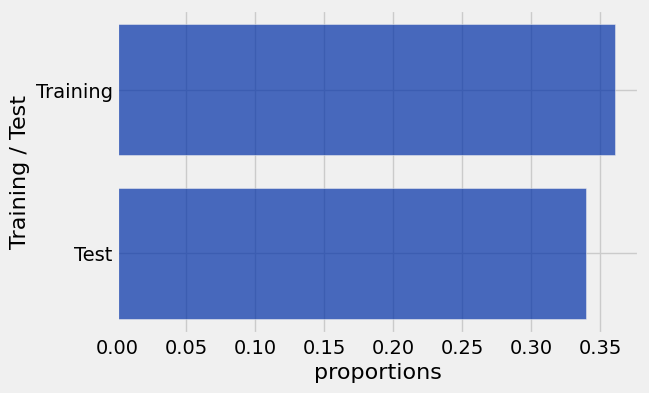

In [88]:
def comedy_proportion(table):
    # Return the proportion of movies in a table that have the comedy genre.
    comedy_prop = table.where("Genre", are.equal_to("comedy")).num_rows/ table.num_rows
    return comedy_prop

com_prop = Table().with_column("Training / Test", make_array("Training", "Test")).with_column("proportions", make_array(comedy_proportion(train_movies), comedy_proportion(test_movies)))


# The staff solution took multiple lines.  Start by creating a table.
# If you get stuck, think about what sort of table you need for barh to work
com_prop.barh("Training / Test", "proportions")


<!-- END QUESTION -->

# Part 2: K-Nearest Neighbors - A Guided Example

K-Nearest Neighbors (k-NN) is a classification algorithm.  Given some numerical *attributes* (also called *features*) of an unseen example, it decides which category that example belongs to based on its similarity to previously seen examples. Predicting the category of an example is called *labeling*, and the predicted category is also called a *label*.

An attribute (feature) we have about each movie is *the proportion of times a particular word appears in the movie*, and the labels are two movie genres: comedy and thriller.  The algorithm requires many previously seen examples for which both the attributes and labels are known: that's the `train_movies` table.

To build understanding, we're going to visualize the algorithm instead of just describing it.

## 2.1. Classifying a movie

In k-NN, we classify a movie by finding the `k` movies in the *training set* that are most similar according to the features we choose. We call those movies with similar features the *nearest neighbors*.  The k-NN algorithm assigns the movie to the most common category among its `k` nearest neighbors.

Let's limit ourselves to just 2 features for now, so we can plot each movie.  The features we will use are the proportions of the words "water" and "feel" in the movie.  Taking the movie *Monty Python and the Holy Grail* (in the test set), 0.000804074 of its words are "water" and 0.0010721 are "feel". This movie appears in the test set, so let's imagine that we don't yet know its genre.

First, we need to make our notion of similarity more precise.  **We will say that the *distance* between two movies is the straight-line distance between them when we plot their features on a scatter diagram.**

**This distance is called the Euclidean ("yoo-KLID-ee-un") distance, whose formula is $\sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}$.**

For example, in the movie *Clerks.* (in the training set), 0.00016293 of all the words in the movie are "water" and 0.00154786 are "feel".  Its distance from *Monty Python and the Holy Grail* on this 2-word feature set is $\sqrt{(0.000804074 - 0.000162933)^2 + (0.0010721 - 0.00154786)^2} \approx 0.000798379$.  (If we included more or different features, the distance could be different.)

A third movie, *The Godfather* (in the training set), has 0 "water" and 0.00015122 "feel". 

The function below creates a plot to display the "water" and "feel" features of a test movie and some training movies. As you can see in the result, *Monty Python and the Holy Grail* is more similar to *Clerks.* than to the *The Godfather* based on these features, which makes sense as both movies are comedy movies, while *The Godfather* is a thriller.

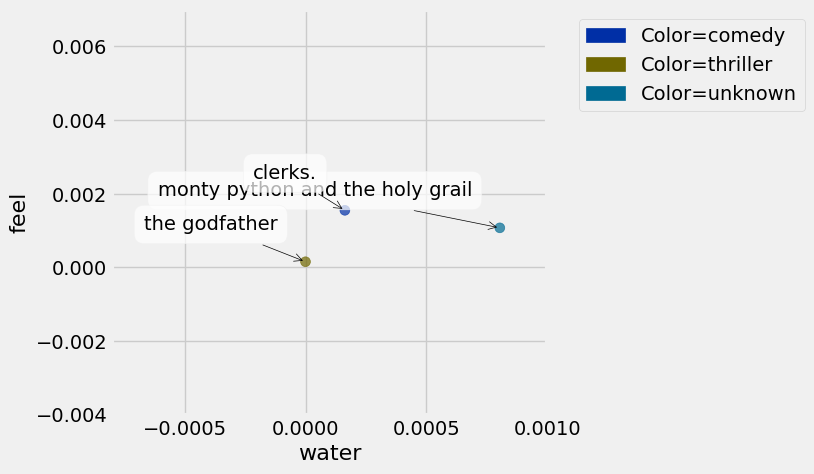

In [89]:
# Just run this cell.
def plot_with_two_features(test_movie, training_movies, x_feature, y_feature):
    """Plot a test movie and training movies using two features."""
    test_row = row_for_title(test_movie)
    distances = Table().with_columns(
            x_feature, [test_row.item(x_feature)],
            y_feature, [test_row.item(y_feature)],
            'Color',   ['unknown'],
            'Title',   [test_movie]
        )
    for movie in training_movies:
        row = row_for_title(movie)
        distances.append([row.item(x_feature), row.item(y_feature), row.item('Genre'), movie])
    distances.scatter(x_feature, y_feature, group='Color', labels='Title', s=50)
    
training = ["clerks.", "the godfather"] 
plot_with_two_features("monty python and the holy grail", training, "water", "feel")
plots.axis([-0.0008, 0.001, -0.004, 0.007]);

Compute the Euclidean distance (defined in the section above) between the two movies, *Monty Python and the Holy Grail* and *The Godfather*, using the `water` and `feel` features only.  Assign it the name `one_distance`. 

In [90]:
python = row_for_title("monty python and the holy grail") 
godfather = row_for_title("the godfather") 

def distance(arr1, arr2):
    return np.sqrt(sum(pow(arr2 - arr1, 2)))
one_distance = np.sqrt(sum(pow(movies.where("Title", "monty python and the holy grail").column("water") - movies.where("Title", "the godfather").column("water"), 2)
+ pow(movies.where("Title", "monty python and the holy grail").column("feel") - movies.where("Title", "the godfather").column("feel"), 2)))
one_distance

np.float64(0.0012225209151294461)

Below, we've added a third training movie, *The Silence of the Lambs*. Before, the point closest to *Monty Python and the Holy Grail* was *Clerks.*, a comedy movie. However, now the closest point is *The Silence of the Lambs*, a thriller movie.

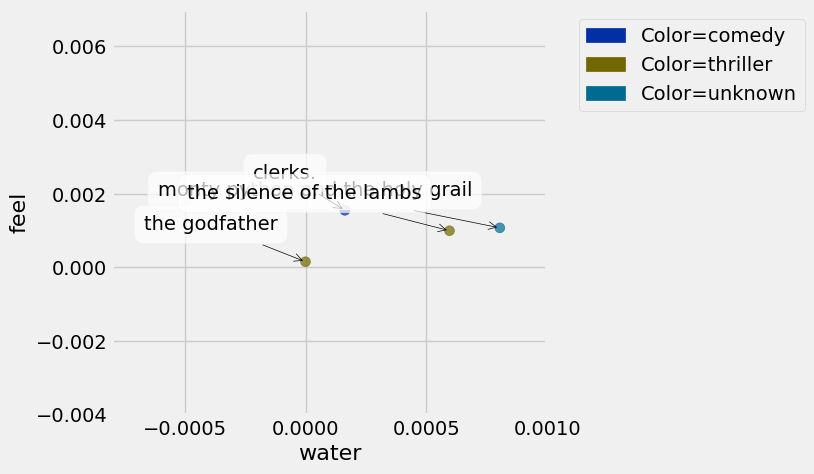

In [91]:
training = ["clerks.", "the godfather", "the silence of the lambs"] 
plot_with_two_features("monty python and the holy grail", training, "water", "feel") 
plots.axis([-0.0008, 0.001, -0.004, 0.007]);

#### Question 2.1.2
Complete the function `distance_two_features` that computes the Euclidean distance between any two movies, using two features. The last two lines call your function to show that *Monty Python and the Holy Grail* is closer to *The Silence of the Lambs* than it is to *Clerks*. 

In [92]:
def distance_two_features(title0, title1, x_feature, y_feature):
    """Compute the distance between two movies with titles title0 and title1.
    
    Only the features named x_feature and y_feature are used when computing the distance.
    """
    row0 = movies.where("Title", title0)
    row1 = movies.where("Title", title1)
    one_distance = np.sqrt(sum(pow(row0.column(x_feature) - row1.column(x_feature), 2)
+ pow(row0.column(y_feature) - row1.column(y_feature), 2)))
    return one_distance
    

for movie in make_array("clerks.", "the silence of the lambs"):
    movie_distance = distance_two_features(movie, "monty python and the holy grail", "water", "feel")
    print(movie, 'distance:\t', movie_distance)

clerks. distance:	 0.0007983810687227716
the silence of the lambs distance:	 0.00022256314855564847


#### Question 2.1.3
Define the function `distance_from_python` so that it works as described in its documentation/
[docstring](https://www.geeksforgeeks.org/python-docstrings/)(the string right below where the function is defined).

In [93]:
def distance_from_python(title):
    """Return the distance between the given movie and "monty python and the holy grail", 
    based on the features "water" and "feel".
    
    This function takes a single argument:
      title: A string, the name of a movie.
    """
    row0 = movies.where("Title", title)
    row1 = movies.where("Title", "monty python and the holy grail")
    #one_distance = np.sqrt(sum(pow(row0.column("water") - row1.column("water"), 2)
    #                          + pow(row0.column("feel") - row1.column("feel"), 2)))

    one_distance = distance_two_features(title, "monty python and the holy grail", "water", "feel")
    return one_distance
    

# Calculate the distance between "Clerks." and "Monty Python and the Holy Grail"
distance_from_python('clerks.')

np.float64(0.0007983810687227716)

Using the features `water` and `feel`, what are the names and genres of the 5 movies in the **training set** closest to *Monty Python and the Holy Grail*?  To answer this question, make a **table** named `close_movies` containing those 5 movies with columns `"Title"`, `"Genre"`, `"water"`, and `"feel"`, as well as a column called `"distance from python"` that contains the distance from *Monty Python and the Holy Grail*.  The table should be **sorted in ascending order by `"distance from python"`**.

In [94]:
# The staff solution took multiple lines.
close_movies = train_movies.with_column("distance from python", train_movies.apply(distance_from_python, "Title")).sort("distance from python", descending = True).select("Title", "Genre", "water", "feel", "distance from python").take(np.arange(5))
close_movies

Title,Genre,water,feel,distance from python
a nightmare on elm street 4: the dream master,thriller,0,0.00474308,0.00375801
final destination,thriller,0,0.00452148,0.00354186
chinatown,thriller,0.00412838,0.000133174,0.00345436
jaws 3-d,thriller,0.00381471,0.00027248,0.00311502
thx 1138,thriller,0,0.00353893,0.00259457


Next, we'll classify *Monty Python and the Holy Grail* based on the genres of the closest movies. 

To do so, define the function `most_common` so that it works as described in its documentation below. 

In [95]:
def most_common(label, table):
    """This function takes two arguments:
      label: The label of a column, a string.
      table: A table.
     
    It returns the most common value in the label column of the table.
    In case of a tie, it returns any one of the most common values.    
    """
    most_common = table.group(label).sort("count", descending = True).column(label).item(0)
    return most_common

# Calling most_common on your table of 5 nearest neighbors classifies
# "monty python and the holy grail" as a thriller movie, 3 votes to 2. 
most_common('Genre', close_movies)

'thriller'

# Part 3: Features

Now, we're going to extend our classifier to consider more than two features at a time to see if we can get a better classification of our movies.

Euclidean distance still makes sense with more than two features. For n different features, we compute the difference between corresponding feature values for two movies, square each of the n differences, sum up the resulting numbers, and take the square root of the sum.


Next, use the function you just defined to compute the distance between the first and second movie in the training set using all of the features. (Remember that the first five columns of your tables are not features.)

In [96]:
def distance(features_array1, features_array2): 
    """The Euclidean distance between two arrays of feature values."""
    one_distance = np.sqrt(sum(pow(features_array1 - features_array2, 2)))
    return one_distance

array_values_movie_1  = np.array(movies.drop(np.arange(5)).row(0))
array_values_movie_2 = np.array(movies.drop(np.arange(5)).row(1))
distance_first_to_second = distance(array_values_movie_1, array_values_movie_2)
distance_first_to_second

np.float64(0.033354468908813176)

Using the plot above, make an array of at least 10 common words that you think might let you distinguish between comedy and thriller movies. Make sure to choose words that are frequent enough that every movie contains at least one of them. Don't just choose the most frequent words though--you can do much better.


In [97]:
# Set my_features to an array of at least 10 features (strings that are column labels)

my_features = make_array("she", "talk", "wit", "razor", "slam", "credit", "rai", "hugh", "breez", "conscienc")

# Select the 10 features of interest from both the train and test sets
train_my_features = train_movies.select(my_features)
test_my_features = test_movies.select(my_features)


his test makes sure that you have chosen words such that at least one appears in each movie. If you can't find words that satisfy this test just through intuition, try writing code to print out the titles of movies that do not contain any words from your list, then look at the words they do contain.

Next, let's classify the first movie from our test set using these features.  You can examine the movie by running the cells below. Do you think it will be classified correctly?

In [98]:
print("Movie:")
test_movies.take(0).select('Title', 'Genre').show()
print("Features:")
test_my_features.take(0).show()

Movie:


Title,Genre
ghostbusters ii,comedy


Features:


she,talk,wit,razor,slam,credit,rai,hugh,breez,conscienc
0.00181339,0.00115397,0.000329707,0,0,0,0.00346192,0,0,0


As before, we want to look for the movies in the training set that are most like our test movie.  We will calculate the Euclidean distances from the test movie (using `my_features`) to all movies in the training set.  You could do this with a `for` loop, but to make it computationally faster, we have provided a function, `fast_distances`, to do this for you.  Read its documentation to make sure you understand what it does.  (You don't need to understand the code in its body unless you want to.)

In [99]:
# Just run this cell to define fast_distances.

def fast_distances(test_row, train_table):
    """Return an array of the distances between test_row and each row in train_table.

    Takes 2 arguments:
      test_row: A row of a table containing features of one
        test movie (e.g., test_my_features.row(0)).
      train_table: A table of features (for example, the whole
        table train_my_features)."""
    assert train_table.num_columns < 50, "Make sure you're not using all the features of the movies table."
    assert type(test_row) != datascience.tables.Table, "Make sure you are passing in a row object to fast_distances."
    assert len(test_row) == len(train_table.row(0)), "Make sure the length of test row is the same as the length of a row in train_table."
    counts_matrix = np.asmatrix(train_table.columns).transpose()
    diff = np.tile(np.array(list(test_row)), [counts_matrix.shape[0], 1]) - counts_matrix
    np.random.seed(0) # For tie breaking purposes
    distances = np.squeeze(np.asarray(np.sqrt(np.square(diff).sum(1))))
    eps = np.random.uniform(size=distances.shape)*1e-10 #Noise for tie break
    distances = distances + eps
    return distances

Use the fast_distances function provided above to compute the distance from the first movie in your test set to all the movies in your training set, using your set of features. Make a new table called genre_and_distances with one row for each movie in the training set and two columns:

The "Genre" of the training movie
The "Distance" from the first movie in the test set
Ensure that genre_and_distances is sorted in ascending order by distance to the first test movie.


In [100]:
# The staff solution took multiple lines of code.
genre_and_distances = Table().with_column("Genre", train_movies.column("Genre")).with_column("Distance", fast_distances(test_my_features.row(0), train_my_features)).sort("Distance", descending = False)
genre_and_distances

Genre,Distance
comedy,0.000989718
thriller,0.00157377
thriller,0.00247131
thriller,0.00308823
thriller,0.00317995
thriller,0.00329733
comedy,0.00333666
comedy,0.00336113
thriller,0.00342967
comedy,0.00345924


Now compute the 7-nearest neighbors classification of the first movie in the test set.  That is, decide on its genre by finding the most common genre among its 7 nearest neighbors in the training set, according to the distances you've calculated.  Then check whether your classifier chose the right genre.  (Depending on the features you chose, your classifier might not get this movie right, and that's okay.)


In [101]:
# Set my_assigned_genre to the most common genre among these.

def distance_from_python_1st(title):
    """Return the distance between the given movie and "monty python and the holy grail", 
    based on the features "water" and "feel".
    
    This function takes a single argument:
      title: A string, the name of a movie.
    """
    one_distance = distance_two_features(title, train_movies.column("Title").item(0), "water", "feel")
    return one_distance
close_movies_7_nearest = genre_and_distances.take(np.arange(7))
my_assigned_genre = most_common('Genre', close_movies_7_nearest)

# Set my_assigned_genre_was_correct to True if my_assigned_genre
# matches the actual genre of the first movie in the test set, False otherwise.
my_assigned_genre_was_correct = np.count_nonzero(test_movies.column("Genre").item(0) == my_assigned_genre)

print("The assigned genre, {}, was{}correct.".format(my_assigned_genre, " " if my_assigned_genre_was_correct else " not "))

The assigned genre, thriller, was not correct.


Write a function called `classify`.  It should take the following four arguments:
* A row of features for a movie to classify (e.g., `test_my_features.row(0)`).
* A table with a column for each feature (e.g., `train_my_features`).
* An array of classes (e.g. the labels "comedy" or "thriller") that has as many items as the previous table has rows, and in the same order. *Hint:* What are the labels of each row in the training set? 
* `k`, the number of neighbors to use in classification.

It should return the class (the string `'comedy'` or the string `'thriller'`) a `k`-nearest neighbor classifier picks for the given row of features. 

In [102]:
def classify(test_row, train_features, train_labels, k):
    """Return the most common class among k nearest neigbors to test_row."""
    distances = fast_distances(test_row, train_features)
    genre_and_distances = Table().with_column("distance 2", distances).with_column("label", train_labels)
    nearest_neighbors = genre_and_distances.sort("distance 2", descending = False).take(np.arange(k))
    most_common_label = most_common("label", nearest_neighbors)
    return most_common_label

Assign `godzilla_genre` to the genre predicted by your classifier for the movie "godzilla" in the test set, using **15 neighbors** and using your 10 features. 

In [103]:
# The staff solution first defined a row called godzilla_features.
godzilla_features = train_movies.where("Title", are.equal_to("godzilla")).select(my_features).drop(np.arange(5))
godzilla_genre = classify(test_movies.where("Title", are.equal_to("godzilla")).select(my_features).row(0), train_my_features, train_movies.column("Genre"), 15)
godzilla_genre

'thriller'

Create a classification function that takes as its argument a row containing your 10 features and classifies that row using the 15-nearest neighbors algorithm with `train_my_features` as its training set. 

In [104]:
def classify_feature_row(row):
    return classify(row, train_my_features, train_movies.column("Genre"), 15)

# When you're done, this should produce 'thriller' or 'comedy'.
classify_feature_row(test_my_features.row(0))

'thriller'

Use `classify_feature_row` and `apply` to classify every movie in the test set.  Assign these guesses as an array to `test_guesses`.  Then, compute the proportion of correct classifications.

In [105]:
test_guesses = test_my_features.with_column("classify feature 1", test_my_features.apply(classify_feature_row)).column("classify feature 1")
proportion_correct = np.count_nonzero(test_guesses == test_movies.column("Genre")) / test_movies.num_rows
proportion_correct

np.float64(0.52)

An important part of evaluating your classifiers is figuring out where they make mistakes. Assign the name `test_movie_correctness` to a table with three columns, `'Title'`, `'Genre'`, and `'Was correct'`. 

- The `'Genre'` column should contain the original genres, not the ones you predicted. 
- The `'Was correct'` column should contain `True` or `False` depending on whether or not the movie was classified correctly.

In [106]:
# Feel free to use multiple lines of code
def was_correct():
    if test_guesses == test_movies.column("Genre"):
        return True
    else:
        return False
# but make sure to assign test_movie_correctness to the proper table!
test_movie_correctness = test_movies.with_column("Was correct", test_guesses == test_movies.column("Genre")).select("Title", "Genre", "Was correct")
test_movie_correctness.sort('Was correct', descending = True).show(5)

Title,Genre,Was correct
psycho,thriller,True
book of shadows: blair witch 2,thriller,True
the getaway,thriller,True
mission: impossible,thriller,True
arctic blue,thriller,True
